In [1]:
import sys

sys.path.append('..')
sys.path.append('../src')

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch.optim import Adam, SGD
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from dotmap import DotMap

from DeepCore.deepcore.nets.nets_utils import recorder
from DeepCore.deepcore.methods.craig import Craig

import warnings

warnings.filterwarnings('ignore')

In [3]:
from data.dataset import PandasDataset as ClassifierDataset

In [4]:
data_path = Path('../data/employee/Employee.csv')
RANDON_SEED = 42

torch.manual_seed(RANDON_SEED)
random.seed(RANDON_SEED)

In [5]:
raw_data = pd.read_csv(data_path)
raw_data.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


# Exploratória

## Data preprocessing

In [6]:
education = {'Bachelors': 0, 'Masters':1, 'PHD': 2}
oce_columns = ["City", "Gender", "EverBenched"]
target_col = 'LeaveOrNot'

data = raw_data.copy()
data['Education'] = data['Education'].map(education)
data = pd.get_dummies(data=data, columns=oce_columns, drop_first=False, dtype=int)

data.head()

,Education,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes
0,0,2017,3,34,0,0,1,0,0,0,1,1,0
1,0,2013,1,28,3,1,0,0,1,1,0,1,0
2,0,2014,3,38,2,0,0,1,0,1,0,1,0
3,1,2016,3,27,5,1,1,0,0,0,1,1,0
4,1,2017,3,24,2,1,0,0,1,0,1,0,1


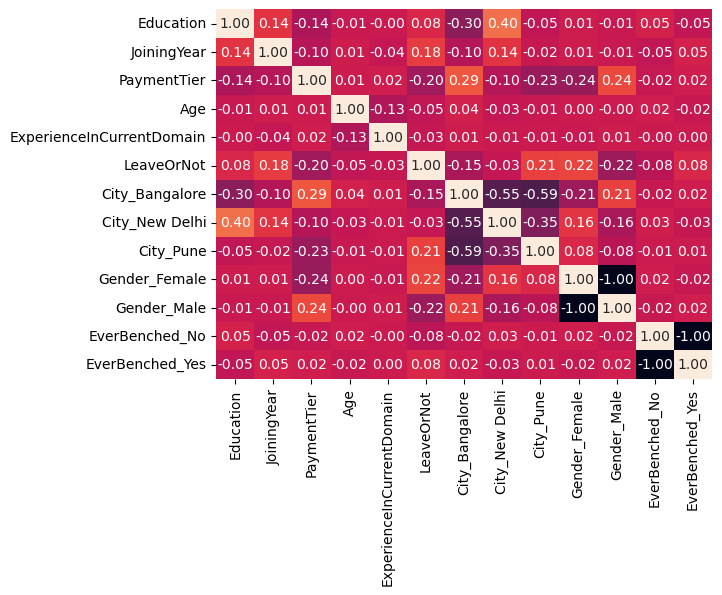

In [7]:
import seaborn as sns
corr = data.corr()

sns.heatmap(corr, annot=True, fmt='.2f', cbar=False)
plt.show()

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

components = data.drop(target_col, axis='columns')

pca = PCA(n_components=2, random_state=RANDON_SEED)

scaler = StandardScaler()
scaler.fit(components)
components = scaler.transform(components)

pca.fit(components)
components = pca.transform(components)
components = pd.DataFrame(data=components, columns=['x', 'y'])
components['target'] = data[target_col]

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

features = data.copy()

train_set, test_set = train_test_split(features, test_size=.2, shuffle=True, random_state=RANDON_SEED)
test_set, val_set = train_test_split(test_set, test_size=.5, shuffle=True, random_state=RANDON_SEED)

train_tgt = train_set[target_col].values
train_ft = train_set.drop(target_col, axis='columns')
feature_names = train_ft.columns.values
train_ft = scaler.transform(train_ft)

test_tgt = test_set[target_col].values
test_ft = test_set.drop(target_col, axis='columns')
test_ft = scaler.transform(test_ft)

model = DecisionTreeClassifier()
model.fit(X=train_ft, y=train_tgt)

pred = model.predict(test_ft)
print(classification_report(test_tgt, pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       316
           1       0.77      0.76      0.77       149

    accuracy                           0.85       465
   macro avg       0.83      0.83      0.83       465
weighted avg       0.85      0.85      0.85       465



In [10]:
val_tgt = val_set[target_col].values
val_ft = val_set.drop(target_col, axis='columns')
val_ft = scaler.transform(val_ft)

pred = model.predict(val_ft)
print(classification_report(val_tgt, pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       294
           1       0.78      0.66      0.72       172

    accuracy                           0.81       466
   macro avg       0.80      0.78      0.79       466
weighted avg       0.80      0.81      0.80       466



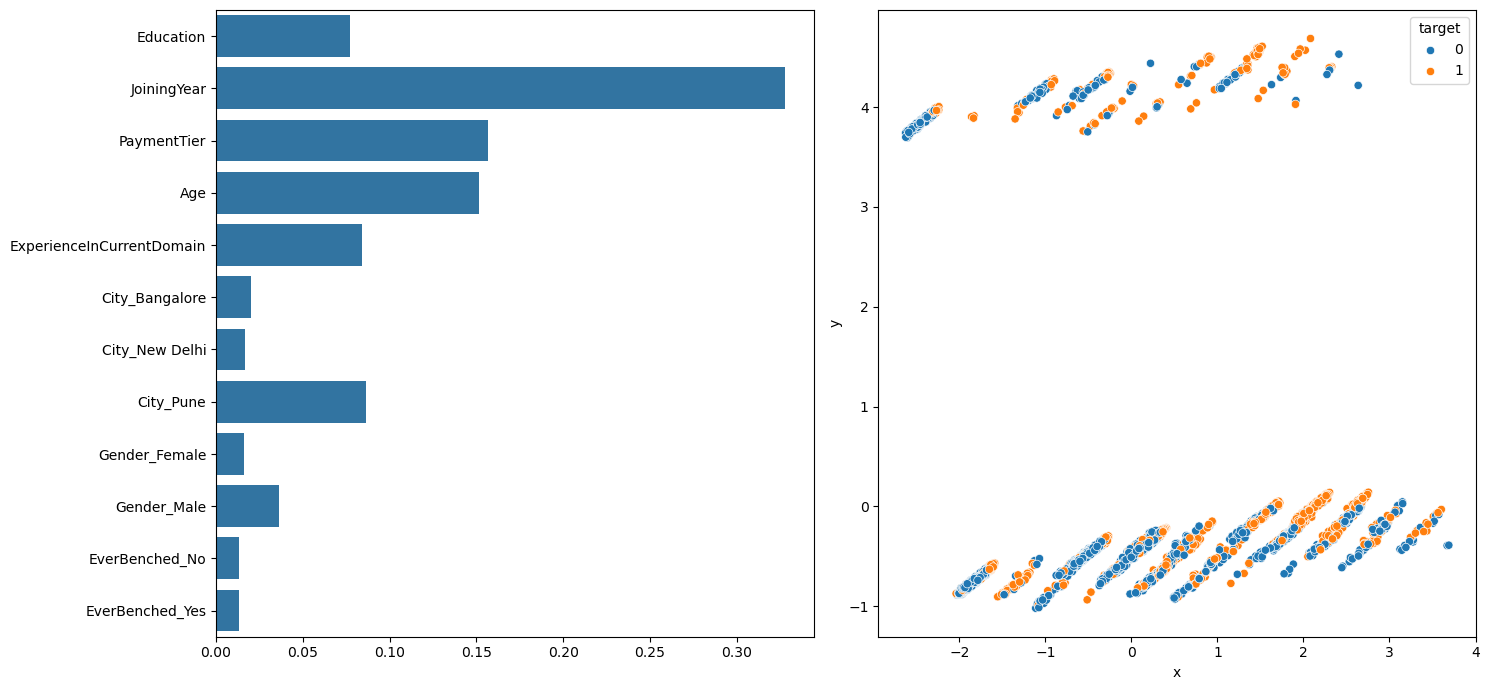

In [11]:
feature_importaces = model.feature_importances_

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.barplot(y=feature_names, x=feature_importaces, orient='h', ax=ax[0])
sns.scatterplot(data=components, x='x', y='y', hue='target', ax=ax[1])
plt.tight_layout()
plt.show()

## Neural net

In [12]:
from model.classifier import EmployeeClassifier as Classifier

In [13]:
import tqdm

def get_device():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return 'mps'
    elif torch.backends.cuda.is_available() and torch.backends.cuda.is_built():
        return 'gpu'
    else:
        return 'cpu'
        

def init_weights(model):
    name = model.__class__.__name__
    if name == 'Linear':
        nn.init.xavier_normal(model.weight)
        model.bias.data.fill_(10e-2)
        
def eval_model(model, ds_loader, loss_fn, device='cpu'):
    eval_loss = 0.0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for sset in ds_loader:
            attr, targets = sset.values()
            attr = torch.Tensor(attr).to(device)
            targets = torch.Tensor(targets).to(device)
            pred = model(attr)
            loss = loss_fn(pred, targets)
            eval_loss += loss.item() / len(ds_loader)
    return eval_loss
        

def train(model, loss_fn, optmizer, train_loader, val_loader, n_epochs, test_loader=None, device='cpu', init=False):
    # inicializa os pesos do modelo
    if init:
        model.apply(init_weights)
        
    model.to(device)
    model.train(True)
    train_loss = []
    val_loss = []
    test_loss = []
    # treinamento epocas
    for _ in tqdm.trange(n_epochs):
        loss_t = 0
        # loop de treinamento
        for sset in train_loader:
            attr, targets = sset.values()
            attr = torch.autograd.Variable(attr, requires_grad=True).float().to(device)
            targets = torch.Tensor(targets).to(device)
            
            pred = model(attr)
            loss = loss_fn(pred, targets)
            loss_t += loss.item() / len(train_loader)
            
            optmizer.zero_grad()
            loss.backward()
            optmizer.step()
        train_loss.append(loss_t)
        loss_v = eval_model(model=model, ds_loader=val_loader, loss_fn=loss_fn)
        val_loss.append(loss_v)
        if test_loader:
            loss_t = eval_model(model=model, ds_loader=test_loader, loss_fn=loss_fn)
            test_loss.append(loss_t)
        hist = {'val_loss':val_loss, 'train_loss': train_loss}
        if test_loader:
            hist['test_loss'] = test_loss
        model.train(True)
    return hist

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.28it/s]


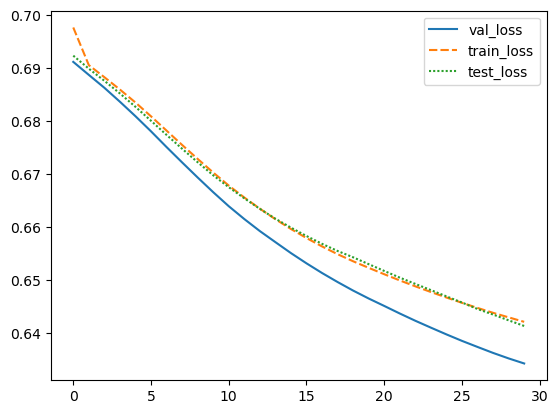

In [14]:
def preprocess(df, target_col, scaler):
    tgt = df[target_col].values
    transformed = df.drop(target_col, axis='columns')
    names = transformed.columns.values
    transformed = scaler.transform(transformed.values)
    transformed = pd.DataFrame(data=transformed, columns=names)
    transformed[target_col] = tgt
    return transformed
    
batch_size = 8
shuffle = True
n_epochs = 30
in_features = len(feature_names) 
out_features = 1
c = 0

# device = torch.device(get_device())
device = 'cpu'

MLP_base = Classifier(in_features=in_features, out_features=1, dropout=.0)

train_set = preprocess(df=train_set, target_col=target_col, scaler=scaler)
ds_train = ClassifierDataset(dataframe=train_set, target=target_col)
ds_train = DataLoader(dataset=ds_train, batch_size=batch_size)

val_set = preprocess(df=val_set, target_col=target_col, scaler=scaler)
ds_val = ClassifierDataset(dataframe=val_set, target=target_col)
ds_val = DataLoader(dataset=ds_val, batch_size=batch_size)

test_set = preprocess(df=test_set, target_col=target_col, scaler=scaler)
ds_test = ClassifierDataset(dataframe=test_set, target=target_col)
ds_test = DataLoader(dataset=ds_test, batch_size=batch_size)

optmizer = Adam(lr=10e-6, params=MLP_base.parameters())
loss_fn = nn.BCELoss()

hist = train(model=MLP_base, train_loader=ds_train, val_loader=ds_val, test_loader=ds_test,loss_fn=loss_fn, optmizer=optmizer, n_epochs=n_epochs, device=device)
hist = pd.DataFrame(hist)


sns.lineplot(data=hist)
plt.show()

## SliceFinder + NN

In [15]:
from torch.nn.functional import binary_cross_entropy as logloss
from sliceline.slicefinder import Slicefinder

eval_dataset = preprocess(df=data, target_col=target_col, scaler=scaler)

with torch.no_grad():
    MLP_base.eval()
    train_pred = torch.Tensor(eval_dataset.drop(target_col, axis='columns').values).float()
    train_pred = MLP_base(train_pred).round().flatten()    
    train_tgt = torch.Tensor(eval_dataset[target_col].values).float()
    # index = (train_pred == 1).numpy()

max_l = len(train_pred)

train_error = logloss(train_pred, train_tgt, reduction='none')

slice_finder = Slicefinder(alpha=.95, k=5)
slice_finder.fit(X=raw_data.drop(target_col, axis=1), errors=train_error)

DEBUG:sliceline.slicefinder:Dropping 2/48 features below min_sup = 10.
DEBUG:sliceline.slicefinder:Initial top-K: count=3, max=0.849077, min=0.090736
DEBUG:sliceline.slicefinder:Level 2:
DEBUG:sliceline.slicefinder: -- generated paired slice candidates: 46 -> 798
DEBUG:sliceline.slicefinder: -- valid slices after eval: 707/798
DEBUG:sliceline.slicefinder: -- top-K: count=5, max=0.849077, min=0.577351
DEBUG:sliceline.slicefinder:Level 3:
DEBUG:sliceline.slicefinder: -- generated paired slice candidates: 707 -> 4204
DEBUG:sliceline.slicefinder: -- valid slices after eval: 2988/4204
DEBUG:sliceline.slicefinder: -- top-K: count=5, max=0.849077, min=0.586449
DEBUG:sliceline.slicefinder:Level 4:
DEBUG:sliceline.slicefinder: -- generated paired slice candidates: 2988 -> 5951
DEBUG:sliceline.slicefinder: -- valid slices after eval: 4960/5951
DEBUG:sliceline.slicefinder: -- top-K: count=5, max=0.849077, min=0.586449
DEBUG:sliceline.slicefinder:Terminated at level 4.


Slicefinder(alpha=0.95, k=5)

In [16]:
from collections import namedtuple

def parse_slices(slice_finder):
    idx = [np.where(i) for i in slice_finder.top_slices_]
    names = [slice_finder.feature_names_in_[i] for i in idx]
    attr = [s[i] for s,i in zip(slice_finder.top_slices_, idx)]
    slices = []
    for name, val in zip(names, attr):
        assert len(name) == len(val), f'len(n){len(name)} != len({len(val)})'
        num = len(name)
        # aux = set((name[i], val[i]) for i in range(num))
        aux = [{'name': name[i], 'value': val[i]} for i in range(num)]
        # print(name)
        slices.append(aux)
    return slices
parse_slices(slice_finder)[0], parse_slices(slice_finder)[2]

([{'name': 'Education', 'value': 'Masters'}],
 [{'name': 'Education', 'value': 'Masters'},
  {'name': 'PaymentTier', 'value': 3}])

## SliceFinder + NN + CRAIG

### Fração - 10%

In [17]:
MLP_craig = Classifier(in_features=in_features, out_features=1, dropout=.0)

optmizer = Adam(lr=10e-6, params=MLP_craig.parameters())
loss_fn = nn.BCELoss()

craig_train_train = preprocess(df=train_set, target_col=target_col, scaler=scaler)
craig_train_train = ClassifierDataset(dataframe=craig_train_train, target=target_col)
craig_train_train = Subset(dataset=craig_train_train, indices=craig_train_train.indices)

In [22]:
args = dict(
    print_freq=10e3,
    num_classes=2,
    # num_classes=MLP_craig.get_last_layer().out_features,
    device="cpu",
    model_optimizer=optmizer,
    batch=256,
    train_batch=256,
    workers=4,
    selection_batch=128,
)
args = DotMap(args)

selection_args = dict(
    epochs=2,
    # epochs=n_epochs,
    balance=True,
    greedy="LazyGreedy",
    fraction=.1,
    fraction_pretrain=.5
)

craig = Craig(
    dst_train=craig_train_train,
    args=args,
    random_seed=RANDON_SEED,
    specific_model=MLP_craig,
    criterion=loss_fn,
    **selection_args,
)
coreset = craig.select()

Using CPU.

=> Training Epoch #0
| Epoch [  0/  2] Iter[  1/ 15]		Loss: 66.4062

=> Training Epoch #1
| Epoch [  1/  2] Iter[  1/ 15]		Loss: 67.9688
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([11, 1]) torch.Size([11, 1])
(2443, 2443) 

In [23]:
import json

with open('coreset.json', 'w') as arq:
    coreset['indices'] = coreset['indices'].tolist()
    coreset['weights'] = coreset['weights'].tolist()
    out = json.dumps(coreset, indent=4)
    arq.writelines(out)


cset_train = data.iloc[coreset['indices']]
print(cset_train.shape)
cset_train = preprocess(df=cset_train, target_col=target_col, scaler=scaler)
cset_train = ClassifierDataset(dataframe=cset_train, target=target_col)
cset_train = DataLoader(dataset=cset_train, batch_size=batch_size)


MLP_craig = Classifier(in_features=in_features, out_features=1, dropout=0)
optmizer = Adam(lr=10e-4, params=MLP_craig.parameters())
loss_fn = nn.BCELoss()

hist_craig = train(model=MLP_craig, train_loader=cset_train, val_loader=ds_val, test_loader=ds_test,loss_fn=loss_fn, optmizer=optmizer, n_epochs=n_epochs, device=device)
hist_craig = pd.DataFrame(hist_craig)

fig, ax = plt.subplots(1, 2, sharey=True)

sns.lineplot(data=hist, ax=ax[0])
sns.lineplot(data=hist_craig, ax=ax[1])
ax[0].set_title("MLP")
ax[1].set_title("MLP+CRAIG")
plt.show()

# eval_dataset = eval_dataset.iloc[coreset['indices']]
eval_dataset = preprocess(df=data, target_col=target_col, scaler=scaler)
# eval_dataset =  pd.concat([test_set, val_set])
# eval_dataset.index = np.arange(len(eval_dataset))

with torch.no_grad():
    MLP_craig.eval()
    train_pred = torch.Tensor(eval_dataset.drop(target_col, axis='columns').values).float()
    train_pred = MLP_craig(train_pred).round().flatten()    
    train_tgt = torch.Tensor(eval_dataset[target_col].values).float()

max_l = len(train_pred)

train_error = logloss(train_pred, train_tgt, reduction='none')

slice_finder = Slicefinder(alpha=.95, max_l=max_l, min_sup=1)
slice_finder.fit(X=raw_data.drop(target_col, axis='columns'), errors=train_error)
parse_slices(slice_finder)

import json
slice_path = Path('results', 'slices', 'craig_10.json')
# slice_path = slice_path.resolve()

with open(slice_path, 'w') as file:
    s = parse_slices(slice_finder)
    s = json.dumps(s, indent=4)
    file.writelines(s)

### Fração - 25%

MLP_craig = Classifier(in_features=in_features, out_features=1, dropout=.0)

optmizer = Adam(lr=10e-6, params=MLP_craig.parameters())
loss_fn = nn.BCELoss()

args = dict(
    print_freq=500,
    num_classes=MLP_craig.get_last_layer().out_features,
    device="cpu",
    model_optimizer=optmizer,
    batch=256,
    train_batch=256,
    workers=4,
    selection_batch=128,
)
args = DotMap(args)

selection_args = dict(
    epochs=n_epochs,
    balance=True,
    greedy="LazyGreedy",
    fraction=.25,
    fraction_pretrain=.5
)
craig = Craig(
    dst_train=craig_train_train,
    args=args,
    random_seed=RANDON_SEED,
    specific_model=MLP_craig,
    criterion=loss_fn,
    **selection_args,
)
coreset = craig.select()

cset_train = data.iloc[coreset['indices']]
print(cset_train.shape)
cset_train = preprocess(df=cset_train, target_col=target_col, scaler=scaler)
cset_train = ClassifierDataset(dataframe=cset_train, target=target_col)
cset_train = DataLoader(dataset=cset_train, batch_size=batch_size)


MLP_craig = Classifier(in_features=in_features, out_features=1, dropout=0)
optmizer = Adam(lr=10e-4, params=MLP_craig.parameters())
loss_fn = nn.BCELoss()

hist_craig = train(model=MLP_craig, train_loader=cset_train, val_loader=ds_val, test_loader=ds_test,loss_fn=loss_fn, optmizer=optmizer, n_epochs=n_epochs, device=device)
hist_craig = pd.DataFrame(hist_craig)

fig, ax = plt.subplots(1, 2, sharey=True)

sns.lineplot(data=hist, ax=ax[0])
sns.lineplot(data=hist_craig, ax=ax[1])
ax[0].set_title("MLP")
ax[1].set_title("MLP+CRAIG")
plt.show()

# eval_dataset = eval_dataset.iloc[coreset['indices']]
# eval_dataset = preprocess(df=data, target_col=target_col, scaler=scaler)

with torch.no_grad():
    MLP_craig.eval()
    train_pred = torch.Tensor(eval_dataset.drop(target_col, axis='columns').values).float()
    train_pred = MLP_craig(train_pred).round().flatten()    
    train_tgt = torch.Tensor(eval_dataset[target_col].values).float()

max_l = len(train_pred)

train_error = logloss(train_pred, train_tgt, reduction='none')

slice_finder = Slicefinder(alpha=.95, max_l=max_l, min_sup=1)
slice_finder.fit(X=raw_data.drop(target_col, axis='columns'), errors=train_error)

slice_path = Path('results', 'slices', 'craig_25.json')
# slice_path = slice_path.resolve()

with open(slice_path, 'w') as file:
    s = parse_slices(slice_finder)
    s = json.dumps(s, indent=4)
    file.writelines(s)

parse_slices(slice_finder)

### Fração - 50%

MLP_craig = Classifier(in_features=in_features, out_features=1, dropout=.0)

optmizer = Adam(lr=10e-6, params=MLP_craig.parameters())
loss_fn = nn.BCELoss()
# main_set = preprocess(df=data, scaler=scaler, target_col=target_col)
# ds_train = ClassifierDataset(dataframe=main_set, target=target_col)
# ds_train = Subset(dataset=ds_train, indices=ds_train.indices)

args = dict(
    print_freq=500,
    num_classes=MLP_craig.get_last_layer().out_features,
    device="cpu",
    model_optimizer=optmizer,
    batch=256,
    train_batch=256,
    workers=4,
    selection_batch=128,
)
args = DotMap(args)

selection_args = dict(
    epochs=n_epochs,
    balance=True,
    greedy="LazyGreedy",
    fraction=.5,
    fraction_pretrain=.5
)
craig = Craig(
    dst_train=craig_train_train,
    args=args,
    random_seed=RANDON_SEED,
    specific_model=MLP_craig,
    criterion=loss_fn,
    **selection_args,
)
coreset = craig.select()

cset_train = data.iloc[coreset['indices']]
print(cset_train.shape)
cset_train = preprocess(df=cset_train, target_col=target_col, scaler=scaler)
cset_train = ClassifierDataset(dataframe=cset_train, target=target_col)
cset_train = DataLoader(dataset=cset_train, batch_size=batch_size)


MLP_craig = Classifier(in_features=in_features, out_features=1, dropout=0)
optmizer = Adam(lr=10e-4, params=MLP_craig.parameters())
loss_fn = nn.BCELoss()

hist_craig = train(model=MLP_craig, train_loader=cset_train, val_loader=ds_val, test_loader=ds_test,loss_fn=loss_fn, optmizer=optmizer, n_epochs=n_epochs, device=device)
hist_craig = pd.DataFrame(hist_craig)

fig, ax = plt.subplots(1, 2, sharey=True)

sns.lineplot(data=hist, ax=ax[0])
sns.lineplot(data=hist_craig, ax=ax[1])
ax[0].set_title("MLP")
ax[1].set_title("MLP+CRAIG")
plt.show()

# eval_dataset = eval_dataset.iloc[coreset['indices']]
# eval_dataset = preprocess(df=data, target_col=target_col, scaler=scaler)

with torch.no_grad():
    MLP_craig.eval()
    train_pred = torch.Tensor(eval_dataset.drop(target_col, axis='columns').values).float()
    train_pred = MLP_craig(train_pred).round().flatten()    
    train_tgt = torch.Tensor(eval_dataset[target_col].values).float()

max_l = len(train_pred)

train_error = logloss(train_pred, train_tgt, reduction='none')

slice_finder = Slicefinder(alpha=.95, max_l=max_l, min_sup=1)
slice_finder.fit(X=raw_data.drop(target_col, axis='columns'), errors=train_error)

slice_path = Path('results', 'slices', 'craig_50.json')

with open(slice_path, 'w') as file:
    s = parse_slices(slice_finder)
    s = json.dumps(s, indent=4)
    file.writelines(s)

parse_slices(slice_finder)